In [0]:
#认证并
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
#挂载云盘
!mkdir -p drive
!google-drive-ocamlfuse drive  -o nonempty

In [0]:
import xgboost as xgb
import pandas as pd

In [0]:
#读取数据
train_csv = pd.read_csv("drive/Colab_Notebooks/data/round1_ijcai_18_train_20180301.txt"," ")
test_csv = pd.read_csv("drive/Colab_Notebooks/data/round1_ijcai_18_test_a_20180301.txt"," ")

In [17]:
#补充时间数据
import time
train_csv['day']=train_csv.context_timestamp.apply(lambda x:time.strftime("%Y-%m-%d",time.localtime(x)))
train_csv['hour']=train_csv.context_timestamp.apply(lambda x:time.strftime("%H",time.localtime(x)))
test_csv['day']=test_csv.context_timestamp.apply(lambda x:time.strftime("%Y-%m-%d",time.localtime(x)))
test_csv['hour']=test_csv.context_timestamp.apply(lambda x:time.strftime("%H",time.localtime(x)))
#展示列名
print("columns length:",len(train_csv.columns))
print("列名：",train_csv.columns)
#时间列
train_time_list = sorted(train_csv["day"].unique())
print("时间序列：",train_time_list)
#分割线下测试和训练集
train_m = train_csv[(train_csv["day"]>='2018-09-17')&(train_csv["day"]<='2018-09-22')]
test_m = train_csv[(train_csv["day"]>='2018-09-23')&(train_csv["day"]<='2018-09-24')]

columns length: 29
列名： Index(['instance_id', 'item_id', 'item_category_list', 'item_property_list',
       'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level',
       'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id',
       'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id',
       'context_timestamp', 'context_page_id', 'predict_category_property',
       'shop_id', 'shop_review_num_level', 'shop_review_positive_rate',
       'shop_star_level', 'shop_score_service', 'shop_score_delivery',
       'shop_score_description', 'is_trade', 'day', 'hour'],
      dtype='object')
时间序列： ['2018-09-17', '2018-09-18', '2018-09-19', '2018-09-20', '2018-09-21', '2018-09-22', '2018-09-23', '2018-09-24']


# 简单数据统计

## 基本数据统计

In [6]:
print('总样本个数:%d' % train_csv.instance_id.unique().shape[0])
print('当前正样本个数为： %d' % len(train_csv[train_csv.is_trade == 1]))
print('当前负样本个数为： %d' % len(train_csv[train_csv.is_trade == 0]))
print('当前商品个数:%d' % train_csv.item_id.unique().shape[0])
print('用户数量：%d' % train_csv.user_id.unique().shape[0])
print('商户数量：%d' % train_csv.shop_id.unique().shape[0])
print('商标数量：%d' % train_csv.item_brand_id.unique().shape[0])
print('广告最大等级为：%d' % max(train_csv['item_price_level']))
print('最大广告销量等级：%d' % max(train_csv['item_sales_level']))
print('最大广告收藏等级:%d' % max(train_csv['item_collected_level']))
print('最大浏览量等级:%d' % max(train_csv['item_pv_level']))
print('用户的预测年龄等级区间为 %d-%d' % (min(train_csv['user_age_level']),max(train_csv['user_age_level'])))
print('用户等级区间为%d-%d' % (min(train_csv['user_star_level']), max(train_csv['user_star_level'])))
print('最大店铺评价数量等级:%d' % max(train_csv['shop_review_num_level']))
print('最大店铺星级编号:%d' % max(train_csv['shop_star_level']))

总样本个数:478087
当前正样本个数为： 9021
当前负样本个数为： 469117
当前商品个数:10075
用户数量：197694
商户数量：3959
商标数量：2055
广告最大等级为：17
最大广告销量等级：17
最大广告收藏等级:17
最大浏览量等级:21
用户的预测年龄等级区间为 -1-1007
用户等级区间为-1-3010
最大店铺评价数量等级:25
最大店铺星级编号:5020


In [7]:
%%time
import time
train_csv['day']=train_csv.context_timestamp.apply(lambda x:time.strftime("%Y-%m-%d",time.localtime(x)))
train_csv['hour']=train_csv.context_timestamp.apply(lambda x:time.strftime("%H",time.localtime(x)))

CPU times: user 1.4 s, sys: 50 ms, total: 1.45 s
Wall time: 1.45 s


每天行为数量
2018-09-17     6659
2018-09-18    77494
2018-09-19    70458
2018-09-20    68681
2018-09-21    71236
2018-09-22    68213
2018-09-23    62869
2018-09-24    52528
Name: day, dtype: int64


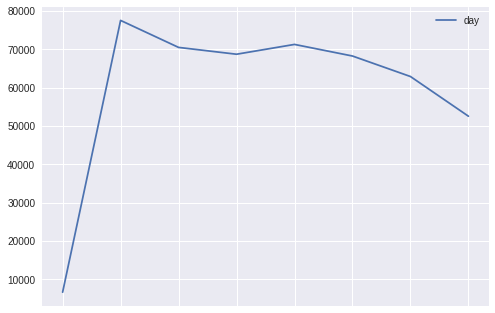

In [9]:
print('每天行为数量')
print(train_csv.day.value_counts().sort_index())
pd.DataFrame(train_csv.day.value_counts().sort_index()).plot()

## item_category_list的统计信息

item_category_list分割后长度最小值： 2  长度最大值： 3


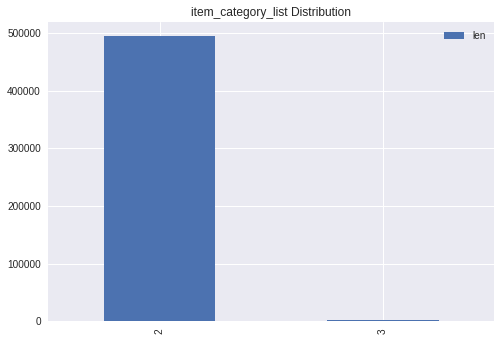

In [9]:
all_data = [train_csv,test_csv]
all_data = pd.concat(all_data)
category_list= list(map(lambda x:len(x.split(";")),all_data["item_category_list"]))
item_category_list = pd.DataFrame({"len":category_list,"list":list(map(lambda x:x.split(";"),all_data["item_category_list"]))})
print("item_category_list分割后长度最小值：",item_category_list["len"].min()," 长度最大值：",item_category_list["len"].max())
pd.DataFrame(item_category_list["len"].value_counts().sort_index()).plot(kind="bar",title="item_category_list Distribution")

# 计算特征

In [0]:
feature_list=[]#特征列表

## 计算item_category_list所有类别信息对应的is_trade数目z-score
感觉区别度不算大，此特征不一定有太大作用

In [63]:
#传入DataFrame而获取对应category的is_trade数目表
def get_category_trade_num(df):
  temp_pd = df[["instance_id","item_category_list","is_trade"]].copy()#返回的DataFrame
  #只留第2个category，第一个category都是一样的
  temp_pd["category"] =  list(map(lambda x:x.split(";")[1],temp_pd["item_category_list"]))
  ret = temp_pd.groupby("category").sum().reset_index()
  ret["is_trade"] = ret["is_trade"].astype(int)
  ret["trade_ratio"] = ret["is_trade"]/len(df)#trade的比例
  ret["trade_ratio_z_score"] = (ret["trade_ratio"]-ret["trade_ratio"].mean())/ret["trade_ratio"].std()#计算z-score
  ret = ret[["category","trade_ratio_z_score"]]
  return ret
category_trade_rate = get_category_trade_num(all_data)
feature_list.append("trade_ratio_z_score")
print(category_trade_rate)

               category  trade_ratio_z_score
0   1968056100269760729            -0.820056
1   2011981573061447208            -0.649341
2     22731265849056483            -0.827218
3   2436715285093487584            -0.768722
4   2642175453151805566            -0.681574
5   3203673979138763595            -0.734101
6   4879721024980945592            -0.792598
7    509660095530134768             0.682951
8   5755694407684602296             1.234491
9   5799347067982556520             0.692502
10  7258015885215914736             1.723953
11  8277336076276184272             1.498323
12  8710739180200009128            -0.558611


## 计算item_property_list对应的特征